# BTC Price Direction Prediction

#### This project is to predict the day price direction of BTC

The crypto market is highly volatile. In order to be profitable, we do not need to predict the correct price, but rather, the price direction. Whether it will be higher or lower than the price that is today. If we predict it to be higher, we might as well buy it, else we should sell. Therefore, our target is a binary classification whether the next day closing price will be higher than the opening price.

We have data for the period from 2014-09-17 up to 2023-05-02. The data is using yahoo finance API.

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt 

In [2]:
start_date = dt.datetime.now() - dt.timedelta(days=3650) # try as far back as possible
end_date = dt.datetime.now()

In [3]:
btc = yf.download('BTC-USD', start=start_date, end=end_date, interval='1d').reset_index()

[*********************100%***********************]  1 of 1 completed


In [4]:
btc.shape

(3150, 7)

In [5]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3150 non-null   datetime64[ns]
 1   Open       3150 non-null   float64       
 2   High       3150 non-null   float64       
 3   Low        3150 non-null   float64       
 4   Close      3150 non-null   float64       
 5   Adj Close  3150 non-null   float64       
 6   Volume     3150 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 172.4 KB


In [6]:
btc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3.150000e+03
mean,13302.969426,13633.769529,12939.761245,13310.507581,13310.507581,1.661397e+10
std,16044.800038,16451.935755,15578.429003,16042.187177,16042.187177,1.971414e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,733.222260,741.033981,716.903015,735.437515,735.437515,1.162850e+08
50%,7416.254883,7573.982910,7270.244385,7420.971436,7420.971436,9.350333e+09
75%,19245.713867,19538.156250,18925.291016,19262.731445,19262.731445,2.794229e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [7]:
btc['Date'].describe() # data ranged from 2014-09-17 ~ 2023-05-02

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/2525939784.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  btc['Date'].describe() # data ranged from 2014-09-17 ~ 2023-05-02


count                    3150
unique                   3150
top       2014-09-17 00:00:00
freq                        1
first     2014-09-17 00:00:00
last      2023-05-02 00:00:00
Name: Date, dtype: object

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,9)

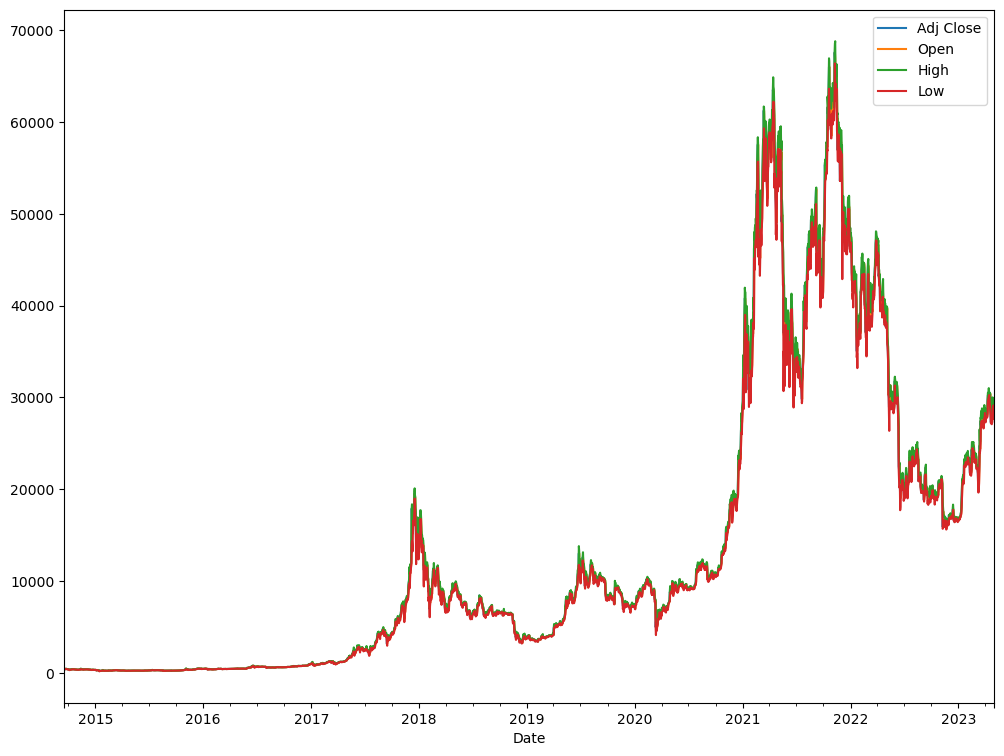

In [9]:
_ = btc.plot(x='Date', y=['Adj Close', 'Open', 'High', 'Low'])

#### Note: there are 2 important halving events happened in the observing period, 2016-07-09 and 2020-05-11. For both halving events, the bitcoin price will rise and peak in 1.5 years later (2017-11-09 for the 2016-07 havling and 2021-11-09 for the 2020-05 halving).

Noticing such pattern, we can slice the data into the following set:

Training Data: bitcoin price (2016-07-09 ~2021-11-09), we want to train the dataset with the entire cycle since BTC halving event.

Validation Data: bitcoin price (2014-09-17 ~ 2017-07-08), using the price history up to the halving date as the validation set.

Testing Data: bitcoin price (2021-11-10 ~ 2023-05-02), testing out the price direction after the peak.

In [10]:
btc_training = btc[(btc['Date'] >= '2016-07-09')&(btc['Date']<='2021-11-09')]
btc_validation = btc[btc['Date']<'2016-07-09']
btc_testing = btc[btc['Date']>'2021-11-09']

In [11]:
print('training set proportion is: ', btc_training['Date'].count()/btc['Date'].count()) 
print('validation set proportion is: ', btc_validation['Date'].count()/btc['Date'].count())
print('testing set proportion is: ', btc_testing['Date'].count()/btc['Date'].count())

training set proportion is:  0.6190476190476191
validation set proportion is:  0.20984126984126983
testing set proportion is:  0.1711111111111111


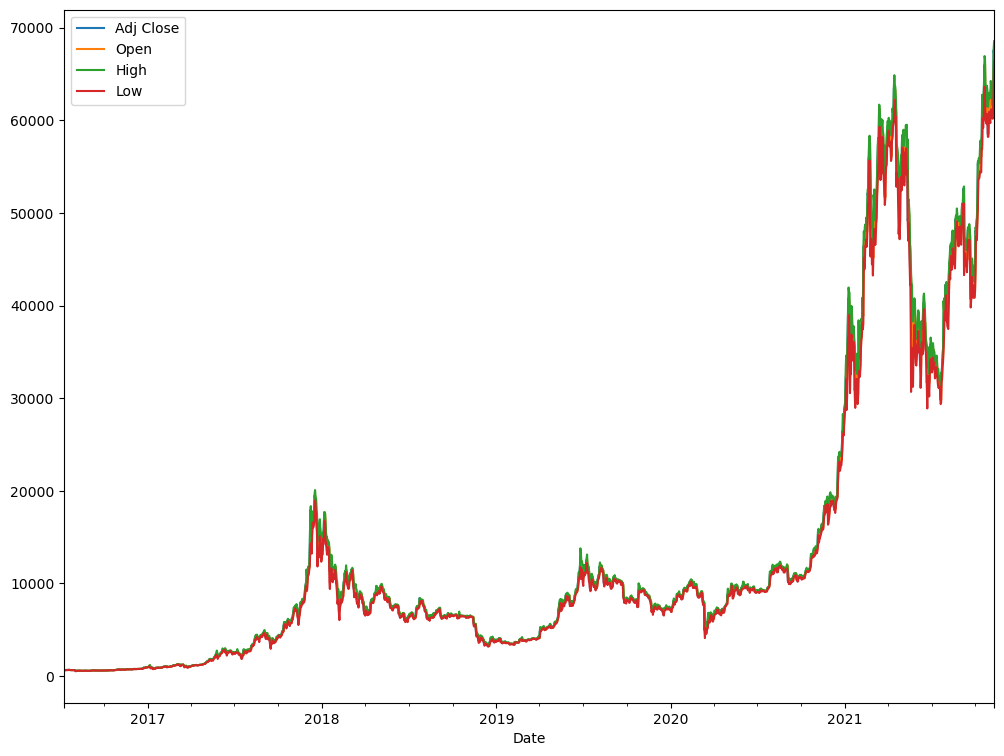

In [12]:
_ = btc_training.plot(x='Date', y=['Adj Close', 'Open', 'High', 'Low'])

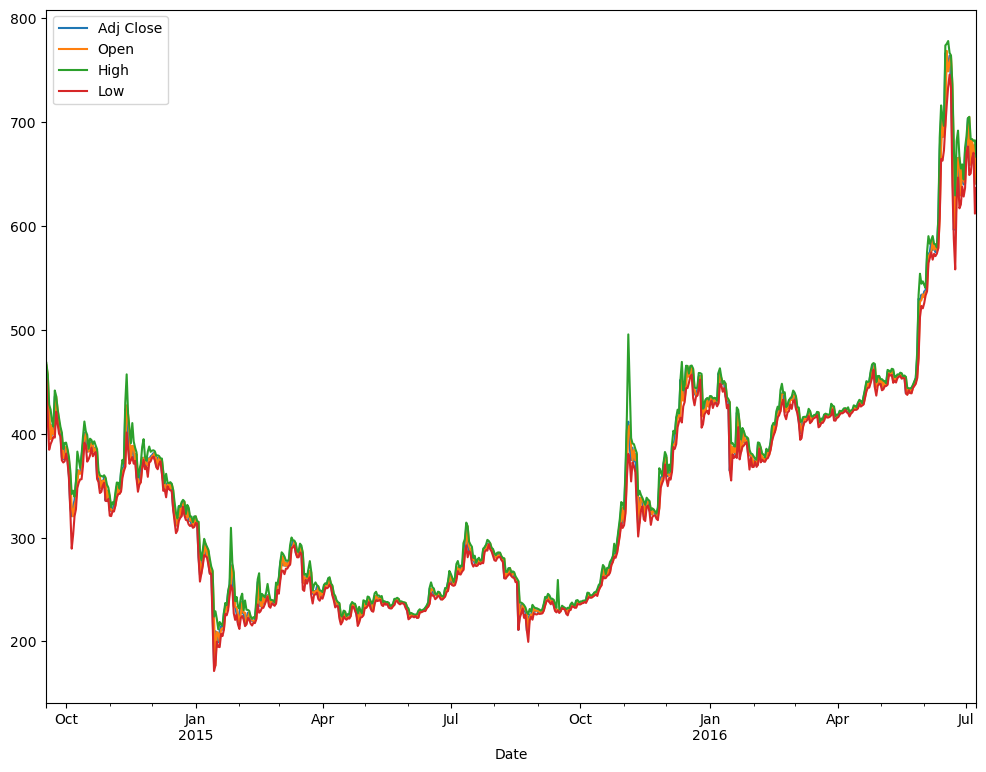

In [13]:
_ = btc_validation.plot(x='Date', y=['Adj Close', 'Open', 'High', 'Low'])

### Once we have done the exploration, we can move to predictive modeling part of the task. The task was to predict if the next day's closing price will be higher than the opening price. 

### We can use a boolen type (0 or 1) to indicate whether the next day's closing price is higher than opening price by creating a new column, call it "Target".

In [14]:
btc_training.sort_values('Date', inplace=True)
btc_validation.sort_values('Date', inplace=True)
btc_testing.sort_values('Date', inplace=True)

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1894145360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training.sort_values('Date', inplace=True)
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1894145360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation.sort_values('Date', inplace=True)
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1894145360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [15]:
btc_training['Target'] = (btc_training['Adj Close']>btc_training['Open']).shift(periods=-1, fill_value=0).astype(int)

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/3895826135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training['Target'] = (btc_training['Adj Close']>btc_training['Open']).shift(periods=-1, fill_value=0).astype(int)


In [16]:
btc_training.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
661,2016-07-09,666.383972,666.383972,633.398987,650.960022,650.960022,180536000,0
662,2016-07-10,650.598999,652.294006,641.263977,649.359985,649.359985,102532000,0
663,2016-07-11,648.484009,659.629028,644.979980,647.658997,647.658997,107910000,1
664,2016-07-12,648.283020,675.258972,646.778992,664.551025,664.551025,138172992,0
665,2016-07-13,664.796997,668.700012,654.468018,654.468018,654.468018,131449000,1
666,2016-07-14,652.922974,662.901978,652.922974,658.078003,658.078003,98511400,1
667,2016-07-15,659.171021,667.077026,659.039978,663.255005,663.255005,81673104,0
668,2016-07-16,663.781006,666.460022,659.333984,660.767029,660.767029,50330200,1
669,2016-07-17,661.992981,682.364990,661.992981,679.458984,679.458984,74407904,0
670,2016-07-18,679.809021,681.554993,668.625000,673.106018,673.106018,69465000,1


In [17]:
btc_training['Target'].value_counts()

1    1067
0     883
Name: Target, dtype: int64

## Repeat the same procedure for our validation and testing set

In [18]:
btc_validation['Target'] = (btc_validation['Adj Close']>btc_validation['Open']).shift(periods=-1, fill_value=0).astype(int)
btc_validation['Target'].value_counts()

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/518951443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation['Target'] = (btc_validation['Adj Close']>btc_validation['Open']).shift(periods=-1, fill_value=0).astype(int)


1    348
0    313
Name: Target, dtype: int64

In [19]:
btc_testing['Target'] = (btc_testing['Adj Close']>btc_testing['Open']).shift(periods=-1, fill_value=0).astype(int)
btc_testing['Target'].value_counts()

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/2561517637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_testing['Target'] = (btc_testing['Adj Close']>btc_testing['Open']).shift(periods=-1, fill_value=0).astype(int)


0    282
1    257
Name: Target, dtype: int64

#### Notice the proportion of price moving up (target=1) in the training set is higher than price going down (target=0), compared to testing and validation. This may lead to bias in prediction. 

Before we do the ML model, it might be useful to engineer some additional feature that may help us better predict the price direction.

## Feature Engineering

We know that the BTC prices are time-dependent, its next day's price depends on price from previous days.

We want to somehow take into account all the values in the last n days, capturing the trend, or the magnitude of price change.

A simple solution would be to calculate a moving average. Let's add 3-day, and 7-day moving average, and add them as a feature into the data set.

In [20]:
btc_training['3d_MA'] = btc_training['Adj Close'] - btc_training['Open'].rolling(window=3, min_periods=1).mean()
btc_validation['3d_MA'] = btc_validation['Adj Close'] - btc_validation['Open'].rolling(window=3, min_periods=1).mean()
btc_testing['3d_MA'] = btc_testing['Adj Close'] - btc_testing['Open'].rolling(window=3, min_periods=1).mean()

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/2047730290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training['3d_MA'] = btc_training['Adj Close'] - btc_training['Open'].rolling(window=3, min_periods=1).mean()
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/2047730290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation['3d_MA'] = btc_validation['Adj Close'] - btc_validation['Open'].rolling(window=3, min_periods=1).mean()
/var/folders/n_/9x9xfmx1

In [21]:
btc_training['7d_MA'] = btc_training['Adj Close'] - btc_training['Open'].rolling(window=7, min_periods=1).mean()
btc_validation['7d_MA'] = btc_validation['Adj Close'] - btc_validation['Open'].rolling(window=7, min_periods=1).mean()
btc_testing['7d_MA'] = btc_testing['Adj Close'] - btc_testing['Open'].rolling(window=7, min_periods=1).mean()

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/627083642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training['7d_MA'] = btc_training['Adj Close'] - btc_training['Open'].rolling(window=7, min_periods=1).mean()
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/627083642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation['7d_MA'] = btc_validation['Adj Close'] - btc_validation['Open'].rolling(window=7, min_periods=1).mean()
/var/folders/n_/9x9xfmx158

Let's also use current day's profit/loss and price range (high-low) as a feature for tomorrow's price direction.

In [22]:
btc_training['Today_Directions'] = btc_training['Adj Close'] - btc_training['Open']
btc_validation['Today_Directions'] = btc_validation['Adj Close'] - btc_validation['Open']
btc_testing['Today_Directions'] = btc_testing['Adj Close'] - btc_testing['Open']

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1088928051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training['Today_Directions'] = btc_training['Adj Close'] - btc_training['Open']
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1088928051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation['Today_Directions'] = btc_validation['Adj Close'] - btc_validation['Open']
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/1088928051.py:3: 

In [23]:
btc_training['Price_Range'] = btc_training['High'] - btc_training['Low']
btc_validation['Price_Range'] = btc_validation['High'] - btc_validation['Low']
btc_testing['Price_Range'] = btc_testing['High'] - btc_testing['Low']

/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/4133871025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_training['Price_Range'] = btc_training['High'] - btc_training['Low']
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/4133871025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_validation['Price_Range'] = btc_validation['High'] - btc_validation['Low']
/var/folders/n_/9x9xfmx15851j2yn0svm5m100000gp/T/ipykernel_46861/4133871025.py:3: SettingWithCopyWarning

Let's see a sample of the data with the new features included

In [24]:
btc_training.sample(10, random_state=42)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,3d_MA,7d_MA,Today_Directions,Price_Range
2275,2020-12-09,18320.884766,18626.292969,17935.546875,18553.916016,18553.916016,34420373071,0,-397.931641,-497.655413,233.031250,690.746094
2066,2020-05-14,9271.329102,9793.268555,9255.035156,9733.721680,9733.721680,56426907637,0,838.020833,475.025251,462.392578,538.233398
1635,2019-03-10,3966.174316,3966.174316,3924.381104,3951.599854,3951.599854,9713267607,0,26.948975,68.836635,-14.574463,41.793213
1716,2019-05-30,8661.760742,9008.314453,8221.273438,8319.472656,8319.472656,29246528551,1,-408.230794,-78.522949,-342.288086,787.041016
968,2017-05-12,1845.760010,1856.150024,1694.010010,1724.239990,1724.239990,740984000,1,-69.976685,32.848546,-121.520020,162.140015
1093,2017-09-14,3875.370117,3920.600098,3153.860107,3154.949951,3154.949951,2716310016,1,-903.793376,-1039.765799,-720.420166,766.739990
2127,2020-07-14,9238.703125,9283.841797,9171.661133,9243.213867,9243.213867,18085038362,0,-9.107096,-40.907087,4.510742,112.180664
1259,2018-02-27,10393.900391,10878.500000,10246.099609,10725.599609,10725.599609,6966179840,0,772.349609,423.153739,331.699219,632.400391
1834,2019-09-25,8603.428711,8744.828125,8325.396484,8486.993164,8486.993164,21744728353,0,-979.911133,-1380.905552,-116.435547,419.431641
966,2017-05-10,1756.520020,1788.439941,1719.099976,1787.130005,1787.130005,915723008,1,94.686646,180.672852,30.609985,69.339966


## Classical ML Algorithms

#### Let's try a few test
1. Logistic regression
2. Decision tree
3. Random forest
4. Gradient boosting ensemble
#### After fitting them to the training data, we are going to evaluate their performance on the validation set by estimating the AUC metric.

In [25]:
y_col = 'Target'
x_cols = [
    'Open',
    'High',
    'Low',
    'Adj Close',
    'Volume',
    '3d_MA',
    '7d_MA',
    'Today_Directions',
    'Price_Range'
]

In [26]:
x_train = btc_training[x_cols]
y_train = btc_training[y_col]

x_validation = btc_validation[x_cols]
y_validation = btc_validation[y_col]

x_test = btc_testing[x_cols]
y_test = btc_testing[y_col]

## 1. Logistic Regression

In [27]:
Random_Seed = 42

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

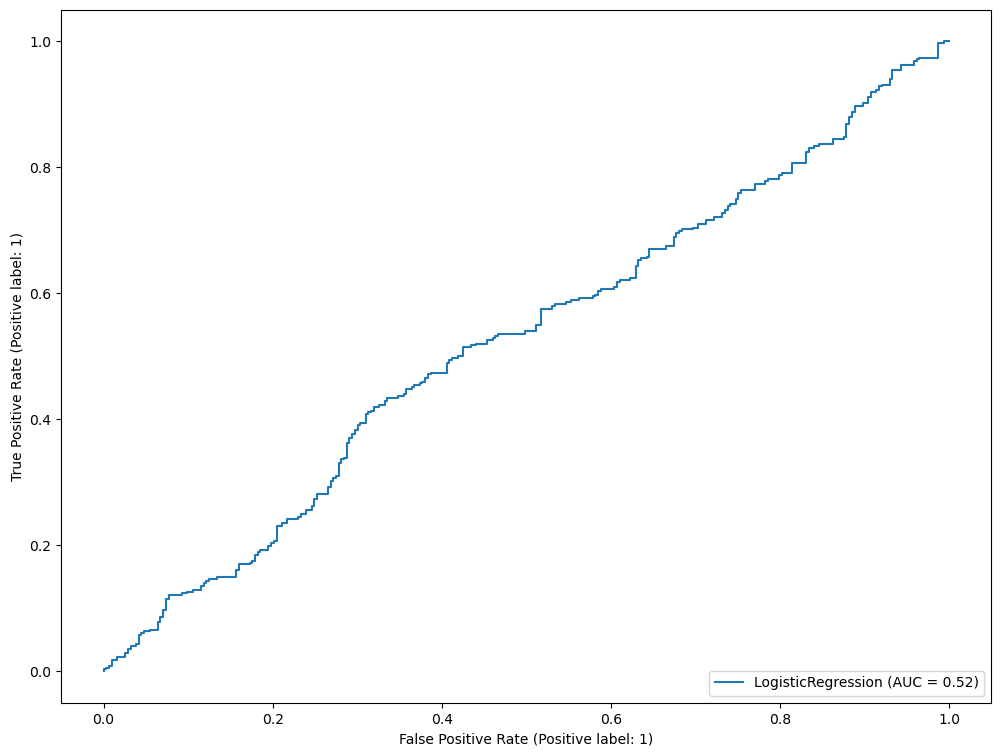

In [33]:
# use default parameter
lr = LogisticRegression()

# fit to train set
lr.fit(x_train, y_train)

# plot ROC curve, and show AUC for the validation set
RocCurveDisplay.from_estimator(lr, x_validation, y_validation)

Okay, the logistic regression prediction is slightly better than flipping a coin (AUC>0.5)

## 2. Decision Tree

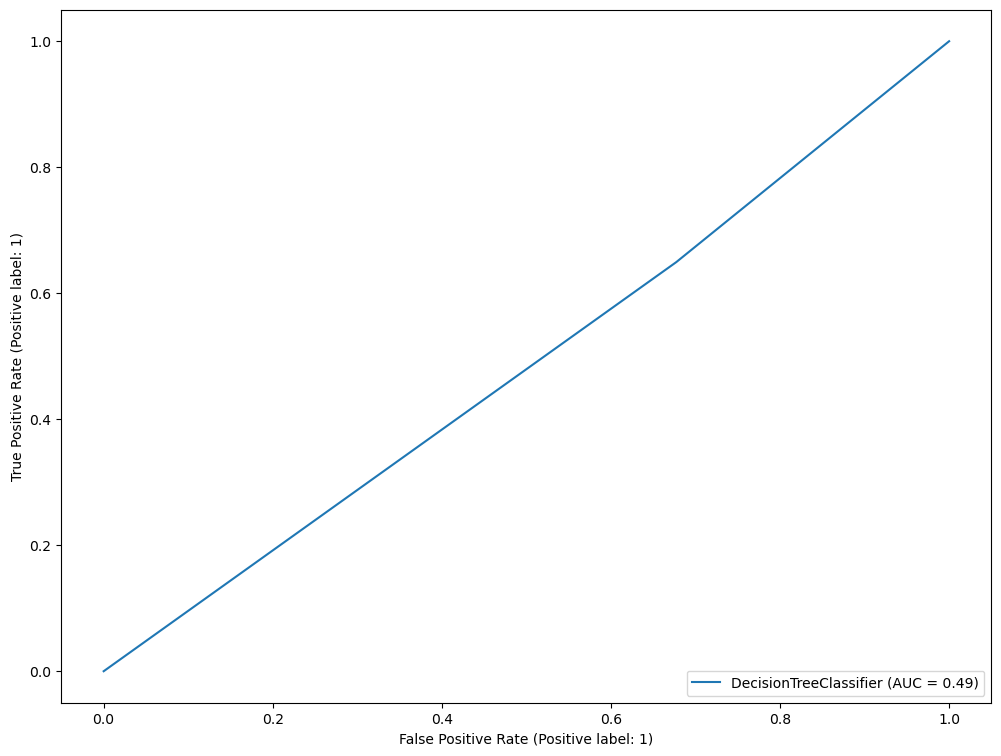

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=Random_Seed)
dt.fit(x_train, y_train)

RocCurveDisplay.from_estimator(dt, x_validation, y_validation)

Decision Tree model does not work well. Having AUC <0.5 means that the classifier is worse than just randomly guessing the output.

## Random Forest

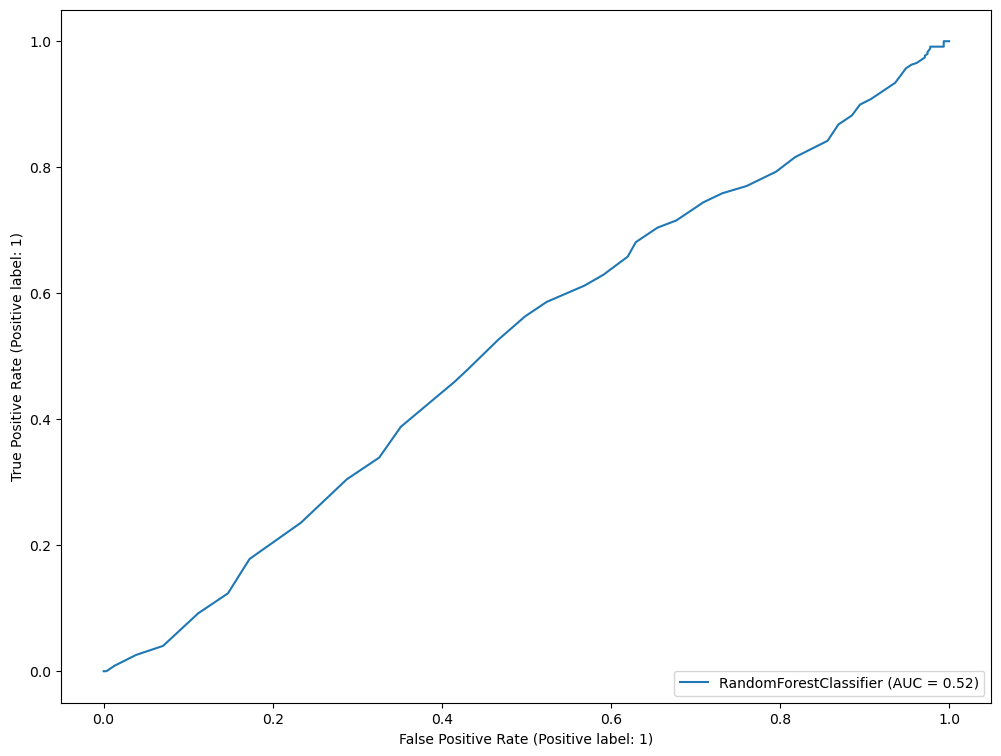

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=Random_Seed)
rf.fit(x_train, y_train)

RocCurveDisplay.from_estimator(rf, x_validation, y_validation)

Random Forest has the same accuracy as the Logistic Regression

## Gradient Boosting Ensemble

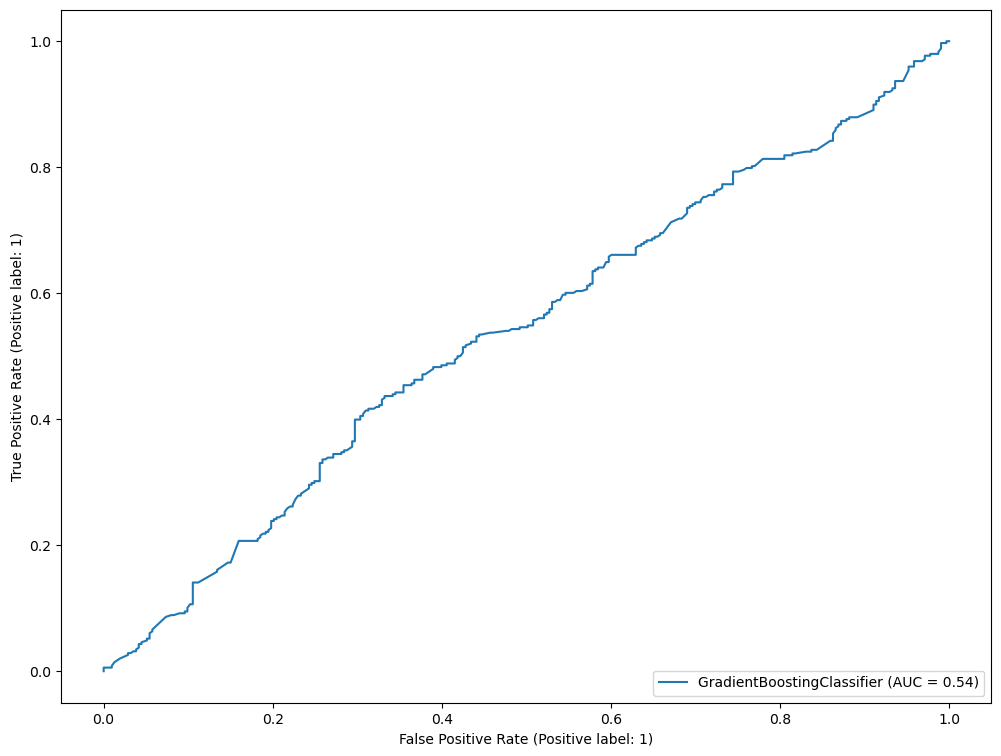

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=Random_Seed)
gb.fit(x_train, y_train)
RocCurveDisplay.from_estimator(gb, x_validation, y_validation)

Gradient Boosting outperforms all previous models and scored 0.54 AUC! It works the best for this data set. 

## Deep Learning Algorithm

Next, let's use Tensorflow for implementing a small neural network.

In [39]:
import tensorflow as tf

tf.random.set_seed(Random_Seed)

print('Tensorflow version', tf.__version__)

2023-05-03 11:26:16.299005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version 2.12.0


#### Use Keras to design a small neural network

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1),
    tf.keras.layers.Dense(10, input_shape=[x_train.shape[1],], activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2, seed=Random_Seed),
    tf.keras.layers.Dense(5, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer='random_normal', bias_initializer='zeros')
])

In [43]:
# this configures the model's loss function, weight optimizer, and metrics to keep track of
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['AUC']
)

I am going to train the model for 50 epochs , and keep track of its loss (binary_crossentropy) and AUC values during each epoch.

To prevent overfitting, I am implementing two variables: (1) learning rate scheduler, and (2) early stopping callback.

In [45]:
def learning_rate_scheduler(epoch, learning_rate):
    if epoch <5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.01)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

In [47]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_validation, y_validation),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping_callback, learning_rate_callback]
)

Epoch 1/50
61/61 [==============================] - 1s 4ms/step - loss: 113552.1250 - auc: 0.5022 - val_loss: 26.6200 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 0s 2ms/step - loss: 14138.2920 - auc: 0.5168 - val_loss: 1.6405 - val_auc: 0.4748 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 0s 2ms/step - loss: 2190.6919 - auc: 0.4805 - val_loss: 7.0952 - val_auc: 0.4916 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 0s 1ms/step - loss: 1008.7780 - auc: 0.5046 - val_loss: 0.6926 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 0s 1ms/step - loss: 341.0163 - auc: 0.4982 - val_loss: 0.6924 - val_auc: 0.5000 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 0s 1ms/step - loss: 168.3685 - auc: 0.5068 - val_loss: 0.6922 - val_auc: 0.5000 - lr: 9.9005e-04
Epoch 7/50
61/61 [==============================] - 0s 1ms/step - loss: 251.6864 - auc: 0.4843 - val_loss: 0.6921 - va

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 180
Trainable params: 161
Non-trainable params: 19
_________________________________________________________

Below, we plot the train and validation loss and AUC values as a function of the epoch, We use the matplotlib library, and the history object to do that.

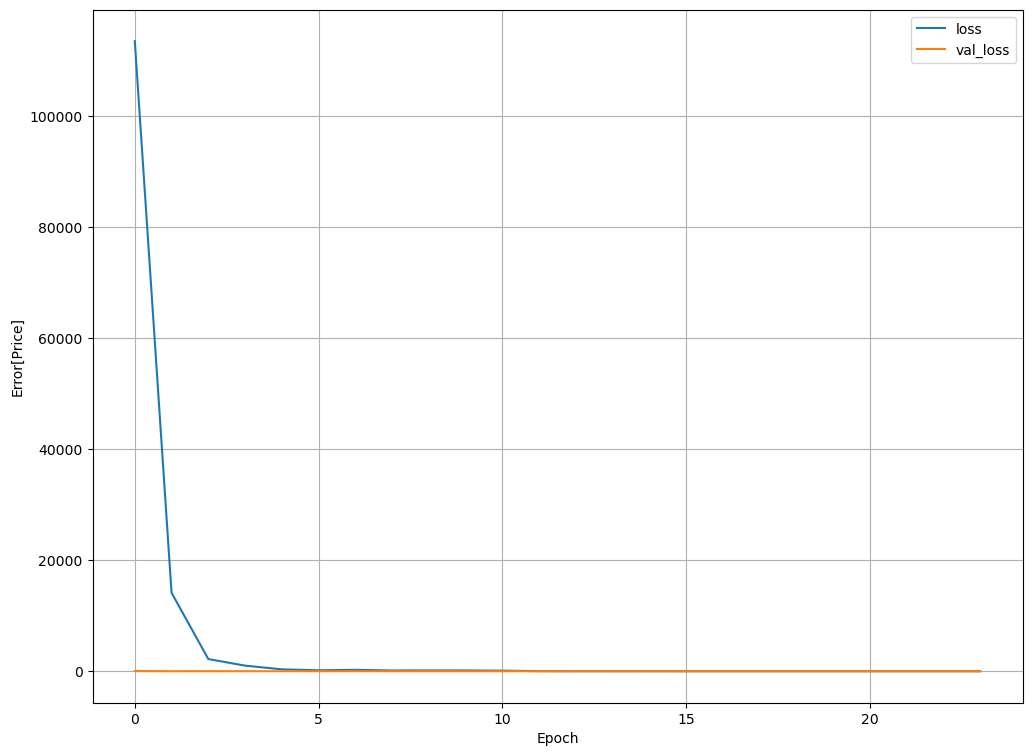

In [50]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error[Price]')
plt.legend()
plt.grid(True)

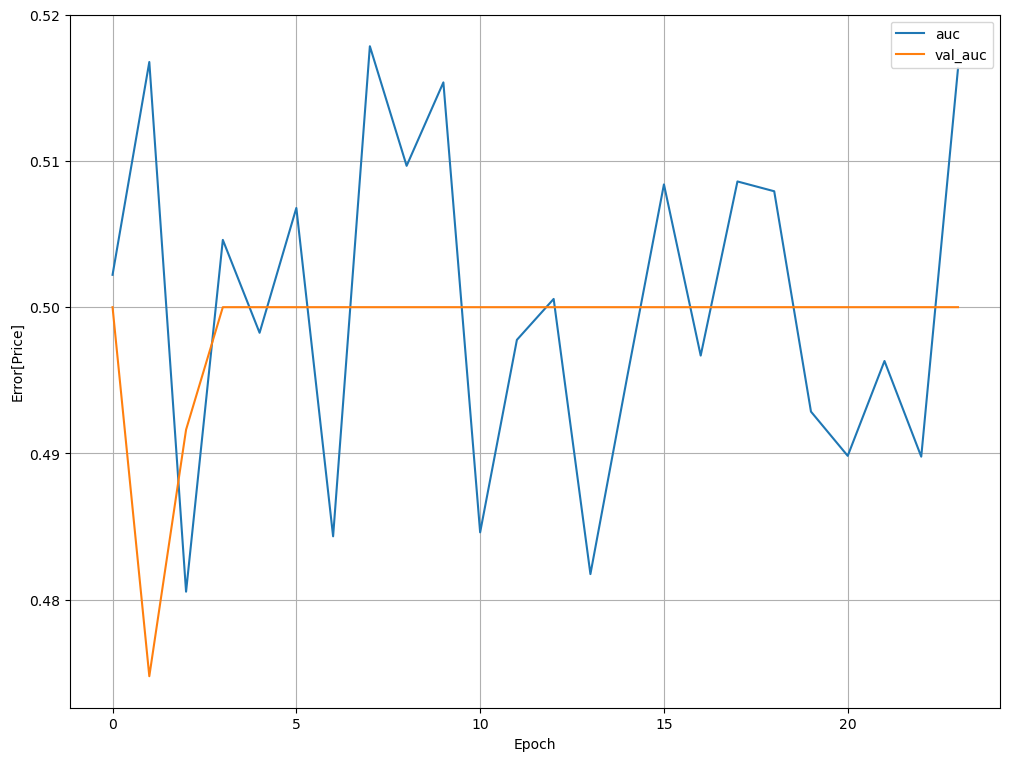

In [51]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Error[Price]')
plt.legend()
plt.grid(True)

## Conclusion

The gradient boosting classifer provided the best AUC score on the validation set. To simulate a production environment, I have held the test set aside until now.

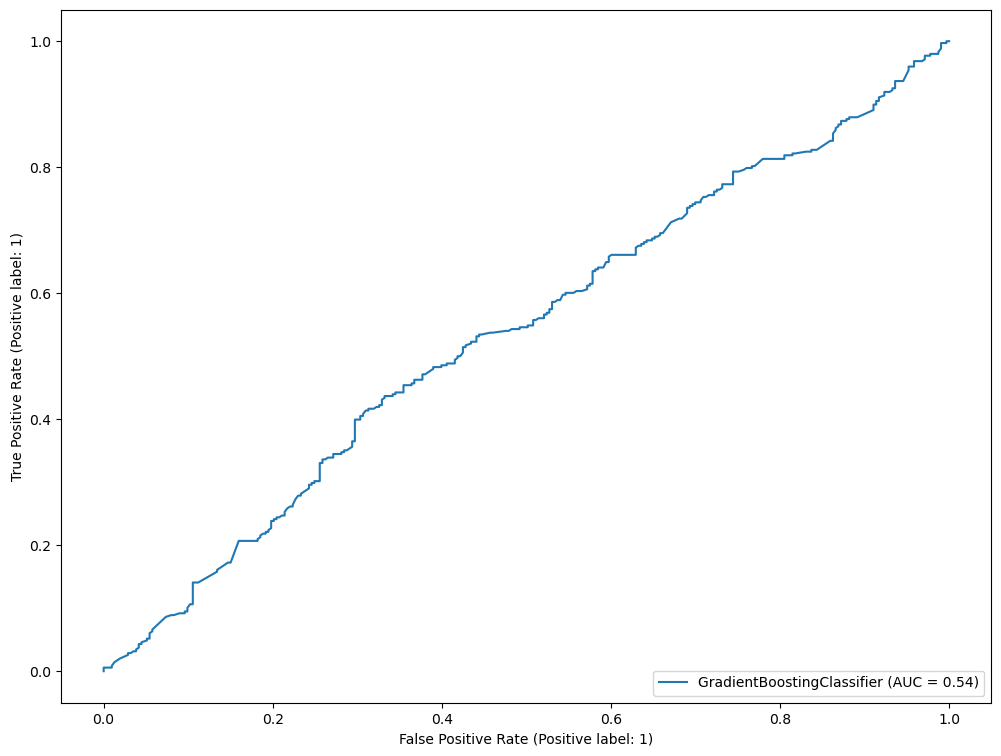

In [52]:
RocCurveDisplay.from_estimator(gb, x_validation, y_validation)

Lastly, I plot a feature importance graph, which plots the importance of each feature in regard to the predictive performance of the model (the higher the value the more important the feature is for determining the value of the target variable).

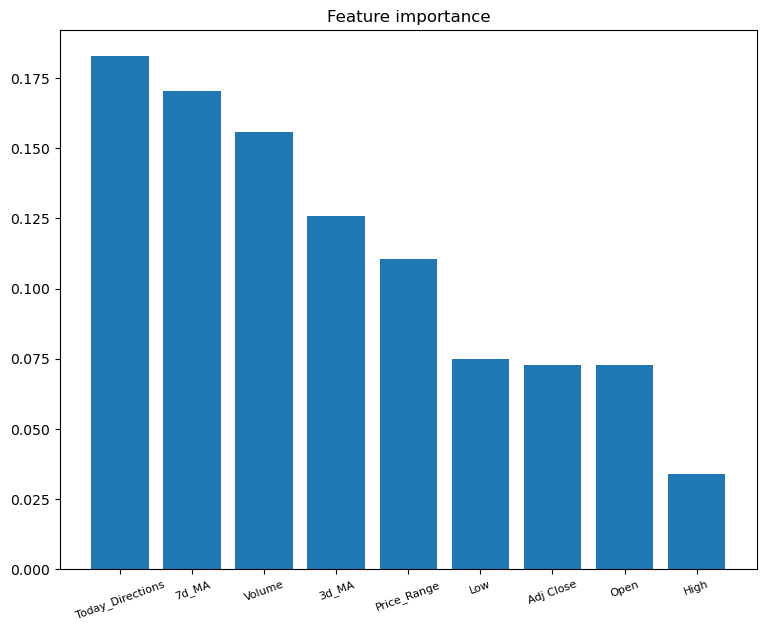

In [55]:
import numpy as np

# Calculate the feature importances
importances = gb.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [btc_training[x_cols].columns[i] for i in indices]

_ = plt.figure(figsize=(9,7))
plt.bar(names, importances[indices])
_ = plt.title('Feature importance')
_ = plt.xticks(rotation=20, fontsize=8)

Today's Direction is the most important feature in predicting tomorrow's price direction. This makes sense since momentum is always an important factor in predicting the BTC price. To better quantify the price movement of BTC, we can use time-series analysis for further studies.